# Setup

## Imports

In [1]:
import QuantumToolbox as qt
using Logging
import CairoMakie as cm
using MiniLoggers
using Revise
using Dates

using ProgressLogging

import LsqFit

import JSON3
import CSV

using DimensionalData

using IJulia
if isdefined(Main, :IJulia)
    Main.IJulia.stdio_bytes[] = 0;
end

0

In [2]:
import SuperconductingCavities as SC

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


## Logger Setups

In [3]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Loading Model

In [4]:
Model = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3LargeTransmon/Mode3LargeTransmon.json");

In [5]:
Model.params["Model_Name"]

"Mode3LargeTransmon"

In [6]:
Model.Stuff

Dict{Any, Any} with 2 entries:
  "op_drive_params"       => Dict{String, Any}()
  "f0g1_stark_shift_fits" => Any[Dict{String, Any}("resid"=>Any[-1.75587e-6, -2…

# How many transmon levels in well? 

In [7]:
52/4

13.0

In [8]:
E_J = Model.hilbertspace.Components["Transmon"].Eʲ
E_C = Model.hilbertspace.Components["Transmon"].Eᶜ
ωp = sqrt(8*E_C*E_J)
println("E_J: $E_J")
println("Expected Number of Bound States: $(2*E_J/ωp)")
energies = real.(Model.hilbertspace.Components["Transmon"].eigsys_full.values);
println("Ground State Energy: $(energies[1])")

println("Number With Difference above groundstate less then Eʲ: $(length(findall(x->x<E_J, energies)))")

E_J: 26.96976142643705
Expected Number of Bound States: 11.451364241340668
Ground State Energy: -24.640602903844393
Number With Difference above groundstate less then Eʲ: 15


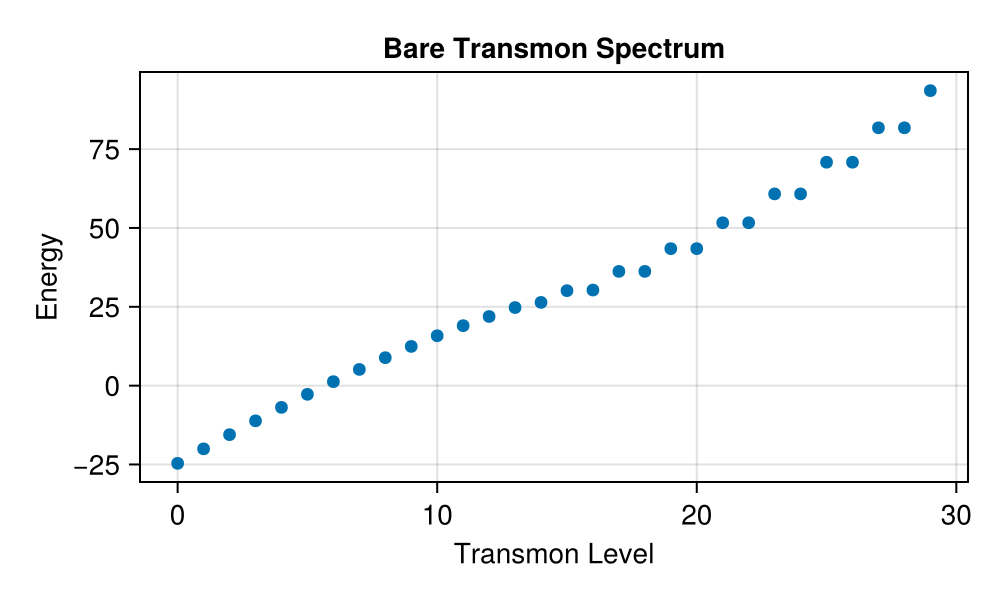

CairoMakie.Screen{IMAGE}


In [9]:
f = cm.Figure(size = (500, 300))
ax = cm.Axis(f[1,1], title = "Bare Transmon Spectrum", xlabel = "Transmon Level", ylabel = "Energy")

y = copy(energies)[1:30]
x = collect(0:(length(y)-1))
cm.scatter!(ax, x, y)

display(f)

# Plotting How Much the dressed states correspond to the bare state $|N\rangle\otimes|\empty\rangle$

In [10]:
overlap_probs = []
for i in 1:Model.params["Nt"]
    T_bare = qt.Qobj(Model.hilbertspace.Components["Transmon"].eigsys.vectors[:,i])
    R_bare = qt.Qobj(Model.hilbertspace.Components["Mode3"].eigsys.vectors[:, 1])
    ψ_bare = qt.tensor(T_bare, R_bare)

    state = (i-1, 0)
    ψ_dressed = Model.dressed_states[state]
    push!(overlap_probs, abs(ψ_dressed'*ψ_bare)^2)
end

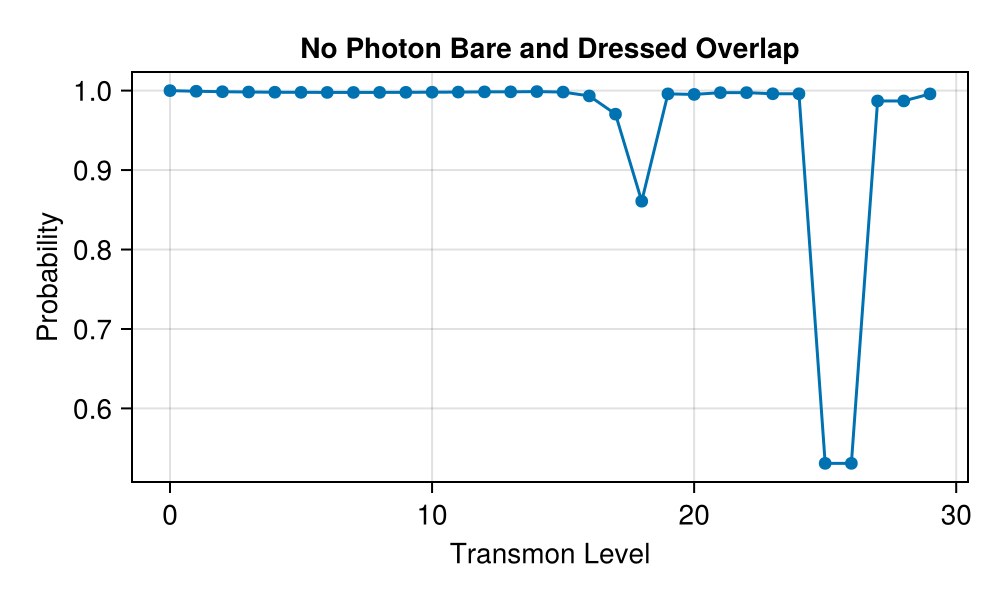

CairoMakie.Screen{IMAGE}


In [11]:
f  = cm.Figure(size = (500, 300))
ax = cm.Axis(f[1,1], title = "No Photon Bare and Dressed Overlap", xlabel = "Transmon Level", ylabel = "Probability")

y = overlap_probs
x = collect(0:(length(y)-1))
cm.scatterlines!(ax, x, y)

display(f)

# Stark Shift Fitting! 

In [1]:
ψf0 = Model.dressed_states[(2,0)]
ψg1 = Model.dressed_states[(0,1)]
ν = Model.dressed_energies[(0,1)] - Model.dressed_energies[(2,0)]

εs = collect(LinRange(0.001, 1, 10))
stark_shift_list = collect(LinRange(0.0, 0.15, 7))
hilbertspace = Model.hilbertspace
Ô_D= Model.n̂ₜ;
#stark_shift_fits = SC.Dynamics.FitStarkShifts(hilbertspace, Ô_D, ψf0, ψg1, ν, εs, stark_shift_list);

UndefVarError: UndefVarError: `Model` not defined

In [23]:
Model.Stuff["f0g1_stark_shift_fits"] = stark_shift_fits
SC.Utils.save_model(Model)

# Doing Floquet Sweep

In [7]:
ψf0 = Model.dressed_states[(2,0)]
ψg1 = Model.dressed_states[(0,1)]
ν0 = Model.dressed_energies[(0,1)] - Model.dressed_energies[(2,0)]

εs = collect(LinRange(0.001, 1, 10))
StarkShiftParams = Model.Stuff["f0g1_stark_shift_fits"][1]["param"]
νs = []
for i in 1:length(εs)
    stark_shift = sum([εs[i]^n*StarkShiftParams[n] for n in 1:length(StarkShiftParams)])
    push!(νs, ν0+stark_shift)
end

params_list = []

for i in 1:length(εs)
    push!(params_list, Dict{Any, Any}("ε" => εs[i], "ν" => νs[i]))
end

floq_sweep = SC.Dynamics.Floquet_t0_Sweep(Model, params_list; states_to_track = Model.dressed_states);

[2024-11-17 17:23:24] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


[2024-11-17 17:25:00] Info: Done With Floquet Sweep
[2024-11-17 17:25:00] Info: Tracking State


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[2024-11-17 17:25:01] Info: Running the necessary time evolutions


In [24]:
to_save = SC.Dynamics.Reformat_Sweep_Results_To_Save(floq_sweep)

open("Floq_Sweep.json", "w") do f
    JSON3.pretty(f, to_save)
end

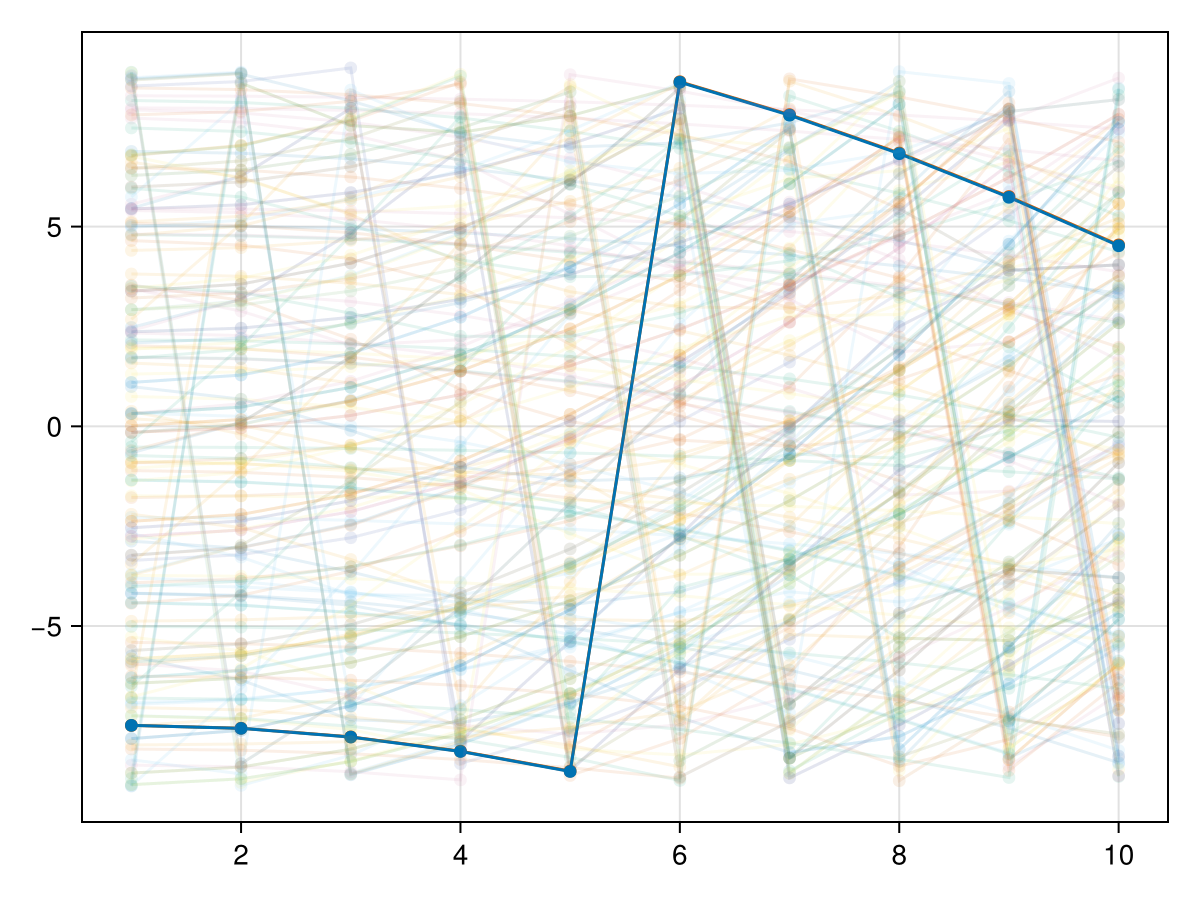

CairoMakie.Screen{IMAGE}


In [ ]:
f = cm.Figure()
ax = cm.Axis(f[1,1], label = "Quasienergies")
states_to_highlight = [string((2,0)), string((0,1))]
for state in keys(to_save)
    num_steps = length(keys(to_save[state]));
    y = []
    for step in 1:num_steps
        push!(y, to_save[state][step]["Quasienergies"])
    end
    alpha = 0.1
    if state in states_to_highlight
        alpha = 1
    end
    cm.lines!(ax, y; alpha = alpha)
    cm.scatter!(ax, y; alpha = alpha)
end

display(f)

In [39]:
step = 2
println(to_save[string((2,0))][step]["Quasienergies"])
println(to_save[string((0,1))][step]["Quasienergies"])

-7.563356728817088
-7.560811548309275
